# Advanced ML - HW5

**Submitted by:**

Yaniv Tal - 031431166

## Flow control parameters

In [114]:
# ENVIRONMENT = 'Local'
ENVIRONMENT = 'Colab'

## General parts - imports, mounts, load data, utility functions etc.

### Imports

In [116]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install pomegranate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
from pathlib import Path

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pygraphviz as pgv
import pomegranate as pg
from pomegranate import BayesianNetwork as bn


if ENVIRONMENT == 'Colab':
    from google.colab import drive

### Mount drive, set paths

In [118]:
if ENVIRONMENT == 'Colab':
  drive.mount('/content/drive')
  PROJECT_ROOT_PATH = Path('/content/drive/MyDrive/colab_data/aml_hw5')

elif ENVIRONMENT == 'Local':
  PROJECT_ROOT_PATH = Path('.')


DATA_PATH = PROJECT_ROOT_PATH / Path('bayesian_mechanic_data_2000_results.csv')
OUTPUT_PATH = PROJECT_ROOT_PATH / Path('outputs')

if not DATA_PATH.exists():
    raise FileNotFoundError('train data file not found!')

if not OUTPUT_PATH.is_dir():
    OUTPUT_PATH.mkdir(parents=True, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download data, to initial dataframe

In [119]:
data = pd.read_csv(DATA_PATH)
# data = data.drop('OR', axis=1)
data.head()

,CHINESE,DATASCI,FAULTY,NOWATER,NOOIL,OR,WATERALERT,TEMPALERT
0,1,1,1,1,1,1,2,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,2,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1


## Answers to task questions


### 1. Bayesian model graph based o domain knowledge

In [120]:
## domain knowledge model - With OR 

states = data.columns.to_list()
print(states)

state_to_index = {key: ind for ind, key in enumerate(states)}

structure = ((), (), (state_to_index["CHINESE"],), (state_to_index["DATASCI"],), (state_to_index["DATASCI"],), (state_to_index["FAULTY"], state_to_index["NOWATER"],), (state_to_index["OR"],), (state_to_index["OR"], state_to_index["NOOIL"],))

model_domain = bn.from_structure(data, state_names=states, structure=structure)
model_domain.bake()


['CHINESE', 'DATASCI', 'FAULTY', 'NOWATER', 'NOOIL', 'OR', 'WATERALERT', 'TEMPALERT']


((), (), (0,), (1,), (1,), (2, 3), (5,), (5, 4))


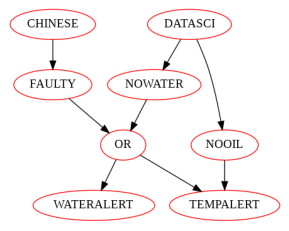

In [121]:
print(model_domain.structure)
model_domain.plot()

### 2. Model graph based on the provided data

In [122]:
model_domain.fit(data)
print()

### 3. d-separation - answers
i.   **True** - {NOOIL} is d-separated from {NOWATER} given {DATASCI}, because the evidence in {DATASCI} blocks the data path. <Br>
ii.  **True** - {DATASCI} is d-separated from {WATERALERT} given {NOWATER}, because the evidence in {NOWATER} blocks the data path <Br>
iii. **True** - {CHINESE} is d-separated from {NOOIL} given {DATASCI} because there is no evidence in {TEMPALERT} <Br>
iv.  **False** {CHINESE} is **NOT** d-separated from {DATASCI, NOOIL} given {TEMPALERT,NOWATER} because the evidence in {TEMPALERT} creates data path in the v-shape above it. <Br>

### 4. Answer the following questions based on the model you have built:

In [123]:
def round_prob_values(prob_dict):
  return {a: round(b, 4) for a, b in zip(prob_dict.keys(), prob_dict.values())}

def compute_probability(model, probability_of, given_that):
    predictions = model.predict_proba(given_that)
    for state, prediction in zip(model.states, predictions):
      if state.name == probability_of:
        print(f"P({state.name} | {given_that}): {round_prob_values(prediction.parameters[0])}")
        # print(f"P({state.name} | {given_that}): {prediction.parameters[0]}")



In [124]:
print('Required probabilities:\n')
compute_probability(model_domain, "NOWATER", {"WATERALERT":2,"TEMPALERT":2})
compute_probability(model_domain, "NOOIL", {"TEMPALERT":2})
compute_probability(model_domain, "FAULTY", {"TEMPALERT":2, "WATERALERT":2})
compute_probability(model_domain, "TEMPALERT", {"DATASCI":2})
compute_probability(model_domain, "WATERALERT", {"DATASCI":1})
compute_probability(model_domain, "WATERALERT", {"CHINESE":2})
compute_probability(model_domain, "NOWATER", {})
compute_probability(model_domain, "FAULTY", {})
compute_probability(model_domain, "FAULTY", {"OR":2})
compute_probability(model_domain, "FAULTY", {"OR":2, "NOWATER":2})

Required probabilities:

P(NOWATER | {'WATERALERT': 2, 'TEMPALERT': 2}): {1: 0.5966, 2: 0.4034}
P(NOOIL | {'TEMPALERT': 2}): {1: 0.2461, 2: 0.7539}
P(FAULTY | {'TEMPALERT': 2, 'WATERALERT': 2}): {1: 0.7429, 2: 0.2571}
P(TEMPALERT | {'DATASCI': 2}): {1: 0.4303, 2: 0.5697}
P(WATERALERT | {'DATASCI': 1}): {1: 0.9322, 2: 0.0678}
P(WATERALERT | {'CHINESE': 2}): {1: 0.9068, 2: 0.0932}
P(NOWATER | {}): {1: 0.9785, 2: 0.0215}
P(FAULTY | {}): {1: 0.9845, 2: 0.0155}
P(FAULTY | {'OR': 2}): {1: 0.5773, 2: 0.4227}
P(FAULTY | {'OR': 2, 'NOWATER': 2}): {1: 0.9845, 2: 0.0155}


### 5. Log probability and Chow-Liu algo

In [125]:
domain_model_lp = model_domain.log_probability(data.to_numpy()).sum()
print(f'Model log probability: {domain_model_lp}')


Model log probability: -3661.007105635488


Chow-Liu model log probability: -3740.6693451746005


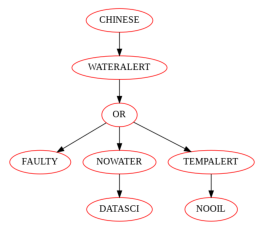

In [126]:
model_chow = bn.from_samples(data, state_names=states, algorithm='chow-liu')
model_chow.bake()
model_chow.plot()
chow_lp = model_chow.log_probability(data.to_numpy()).sum()
print(f'Chow-Liu model log probability: {chow_lp}')


#### Explanation for the model log probability difference:
The domain knowledge model we estabilshed based on domain knowledge is much closer to the exact one (I assume the train data was actually generated based on this logic), hence giving relatively good results (Higher LP).<Br>
The Chau-Liu model is a second order approximation for the optimal tree, hence it is less optimal and has lower LP and captures less of the tree complexity.
This can also be seen in the Chau-Liu tree structure above, which is simpler than the domnain knowledge strcture we created.
